# Compare and evaluate the performance of different models

In [6]:
import json
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')

In [7]:
# load in the json files
def load_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    return data

cr_macro = load_json('./outputs/costarica_resnet_v2.0_macro-accuracy.json')
cr_micro = load_json('./outputs/costarica_resnet_v2.0_micro-accuracy.json')
cr_taxon = load_json('./outputs/costarica_resnet_v2.0_taxon-accuracy.json')

si_macro = load_json('./outputs/singapore_resnet_v2.0_macro-accuracy.json')
si_micro = load_json('./outputs/singapore_resnet_v2.0_micro-accuracy.json')
si_taxon = load_json('./outputs/singapore_resnet_v2.0_taxon-accuracy.json')

uk_macro = load_json('./outputs/uk_resnet_v2.0_macro-accuracy.json')
uk_micro = load_json('./outputs/uk_resnet_v2.0_micro-accuracy.json')
uk_taxon = load_json('./outputs/uk_resnet_v2.0_taxon-accuracy.json')

In [8]:
def summarise_data(macro, micro, taxon):

    # get the Pytorch values
    pytorch_macro = cr_macro['Pytorch']
    tflite_macro = cr_macro['TFLite']
    pytorch_micro = cr_micro['Pytorch']
    tflite_micro = cr_micro['TFLite']

    # create a df with a column for pytorch and tflite, and rows for each value in the dict
    df = pd.DataFrame(columns=['Value', 'Model', 'Type'])
    for k in pytorch_macro.keys():
        df = pd.concat([df, pd.DataFrame([[pytorch_macro[k], "Pytorch", "Macro"]], columns=['Value', 'Model', 'Type'], index=[k])])
        df = pd.concat([df, pd.DataFrame([[tflite_macro[k], "TFLite", "Macro"]], columns=['Value', 'Model', 'Type'], index=[k])])
        df = pd.concat([df, pd.DataFrame([[pytorch_micro[re.sub('macro', 'micro', k)], "Pytorch", "Micro"]], columns=['Value', 'Model', 'Type'], index=[re.sub('macro', 'micro', k)])])
        df = pd.concat([df, pd.DataFrame([[tflite_micro[re.sub('macro', 'micro', k)], "TFLite", "Micro"]], columns=['Value', 'Model', 'Type'], index=[re.sub('macro', 'micro', k)])])

        
    # add a column for species, genus, family deepending on the index
    df['Taxon'] = df.index.str.split('_').str[1]
    df['Measure'] = df.index.str.split('_').str[2]
    return(df)

In [9]:
def bar_plot(df, save=False, col_name='Macro', region='Costa Rica'):
    # set up seaborn mutiplots
    sns.set_style('whitegrid')
    sns.set_context('paper')

    # plot results facet by taxon, and model
    g = sns.catplot(x='Taxon', y='Value', hue='Model', col='Measure', data=df.loc[df['Type']==col_name, ], 
                    kind='bar', height=4, aspect=1, palette=['lightcoral', 'dodgerblue'])

    # add values to top of bars
    for ax in g.axes.flat:
        for p in ax.patches:        
        # if the value is in -0.2, 0.8, or 1.8 then light coral else dodger blue
        if p.get_x()+ p.get_width()/2 in [-0.2, 0.8, 1.8]:
                ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.2f' % p.get_height(), 
                        fontsize=10, color='lightcoral', ha='center', va='bottom')
            else:
                ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.2f' % p.get_height(), 
                        fontsize=10, color='dodgerblue', ha='center', va='bottom')


    g.set_xticklabels(rotation=-45)
    g.set_titles('{col_name}')
    g.set_axis_labels('', f'{col_name} Accuracy')
    g.fig.suptitle(f'{region} Model Performance', fontsize=14, y=1.05)
    g.fig.subplots_adjust(top=0.8)
    if save:
        g.savefig('./outputs/plots/'+ region+'_' + col_name + '.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

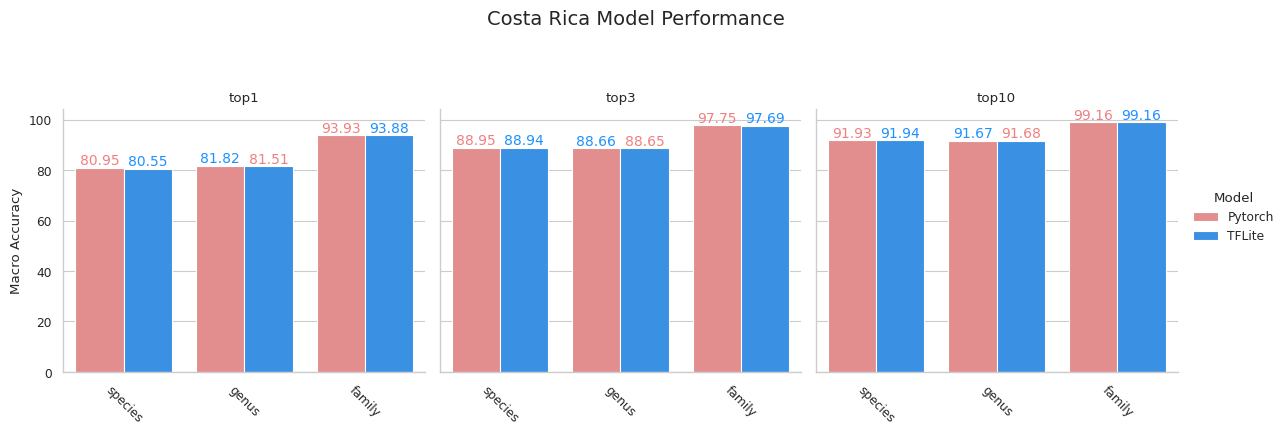

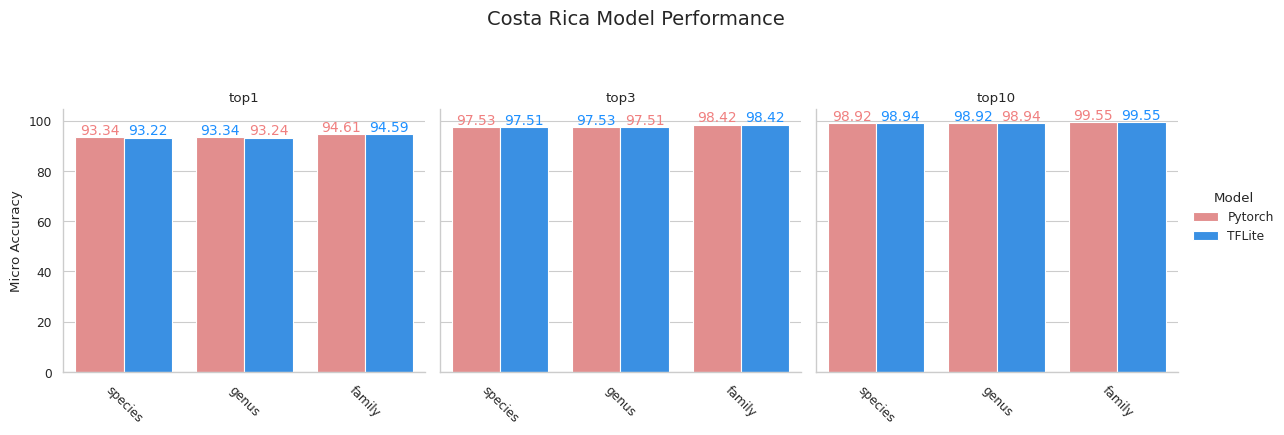

In [10]:
cr_df = summarise_data(cr_micro, cr_macro, cr_taxon)
bar_plot(cr_df, save=True)
bar_plot(cr_df, col_name='Micro', save=True)

In [ ]:
uk_df = summarise_data(uk_micro, uk_macro, uk_taxon)
bar_plot(uk_df, save=True, region='UK')
bar_plot(uk_df, col_name='Micro', save=True, region='UK')

In [ ]:
si_df = summarise_data(si_micro, si_macro, si_taxon)
bar_plot(si_df, save=True, region='Singapore')
bar_plot(si_df, col_name='Micro', save=True, region='Singapore')

# F1 Score

In [31]:
cr_conf = pd.read_csv('./outputs/costarica_resnet_v2.0_confusion-data.csv')
uk_conf = pd.read_csv('./outputs/uk_resnet_v2.0_confusion-data.csv')
si_conf = pd.read_csv('./outputs/singapore_resnet_v2.0_confusion-data.csv')

In [34]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def calculate_metrics(df, ground_truth_col, prediction_col):
    # Get unique types in the ground truth column
    unique_types = df[ground_truth_col].unique()

    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(df[ground_truth_col], df[prediction_col])

    # Extract TP, FP, TN, FN
    TP = conf_matrix[1, 1] if 1 in conf_matrix.shape else 0
    FP = conf_matrix[0, 1] if 0 in conf_matrix.shape else 0
    TN = conf_matrix[0, 0] if 0 in conf_matrix.shape else 0
    FN = conf_matrix[1, 0] if 1 in conf_matrix.shape else 0

    # Calculate Precision, Recall, and F1 Score
    precision = precision_score(df[ground_truth_col], df[prediction_col], average='weighted')
    recall = recall_score(df[ground_truth_col], df[prediction_col], average='weighted')
    f1 = f1_score(df[ground_truth_col], df[prediction_col], average='weighted')

    # Output results as a data frame
    results_df  = pd.DataFrame({'Taxon':[ground_truth_col], 
                                'Model':[prediction_col], 
                                'TP': [TP], 'FP': [FP], 'TN': [TN], 'FN': [FN], 
                                'Precision': [precision], 'Recall': [recall], 'F1': [f1]})

    return results_df

In [39]:
# append them together
cr_df = pd.concat([calculate_metrics(cr_conf, 'F_Truth', 'F_Tf_Prediction'), 
                calculate_metrics(cr_conf, 'G_Truth', 'G_Tf_Prediction'), 
                calculate_metrics(cr_conf, 'S_Truth', 'S_Tf_Prediction'), 
                calculate_metrics(cr_conf, 'F_Truth', 'F_Py_Prediction'), 
                calculate_metrics(cr_conf, 'G_Truth', 'G_Py_Prediction'), 
                calculate_metrics(cr_conf, 'S_Truth', 'S_Py_Prediction')])
cr_df['Region'] = 'Costa Rica'

si_df = pd.concat([calculate_metrics(si_conf, 'F_Truth', 'F_Tf_Prediction'), 
                calculate_metrics(si_conf, 'G_Truth', 'G_Tf_Prediction'), 
                calculate_metrics(si_conf, 'S_Truth', 'S_Tf_Prediction'), 
                calculate_metrics(si_conf, 'F_Truth', 'F_Py_Prediction'), 
                calculate_metrics(si_conf, 'G_Truth', 'G_Py_Prediction'), 
                calculate_metrics(si_conf, 'S_Truth', 'S_Py_Prediction')])
si_df['Region'] = 'Sinapore'

uk_df = pd.concat([calculate_metrics(uk_conf, 'F_Truth', 'F_Tf_Prediction'), 
                calculate_metrics(uk_conf, 'G_Truth', 'G_Tf_Prediction'), 
                calculate_metrics(uk_conf, 'S_Truth', 'S_Tf_Prediction'), 
                calculate_metrics(uk_conf, 'F_Truth', 'F_Py_Prediction'), 
                calculate_metrics(uk_conf, 'G_Truth', 'G_Py_Prediction'), 
                calculate_metrics(uk_conf, 'S_Truth', 'S_Py_Prediction')])
uk_df['Region'] = 'UK'

df = pd.concat([cr_df, si_df, uk_df])

df

/bask/homes/f/fspo1218/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/bask/homes/f/fspo1218/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/bask/homes/f/fspo1218/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/bask/homes/f/fspo1218/.local/lib/python3.9/site-

,Taxon,Model,TP,FP,TN,FN,Precision,Recall,F1,Region
0,F_Truth,F_Tf_Prediction,0,0,0,0,0.946111,0.945941,0.945972,Costa Rica
0,G_Truth,G_Tf_Prediction,0,0,0,0,0.931686,0.932384,0.931581,Costa Rica
0,S_Truth,S_Tf_Prediction,0,0,0,0,0.931258,0.932212,0.931190,Costa Rica
0,F_Truth,F_Py_Prediction,0,0,0,0,0.946287,0.946113,0.946149,Costa Rica
0,G_Truth,G_Py_Prediction,0,0,0,0,0.932732,0.933413,0.932625,Costa Rica
0,S_Truth,S_Py_Prediction,0,0,0,0,0.932445,0.933413,0.932393,Costa Rica
0,F_Truth,F_Tf_Prediction,0,0,0,0,0.945094,0.945078,0.944769,Sinapore
0,G_Truth,G_Tf_Prediction,0,0,0,0,0.897036,0.899656,0.896023,Sinapore
0,S_Truth,S_Tf_Prediction,0,0,0,0,0.864890,0.872090,0.865007,Sinapore
0,F_Truth,F_Py_Prediction,0,0,0,0,0.945452,0.945502,0.945177,Sinapore


In [40]:
# for the Model column, keep only the 2nd word
df['Model'] = df['Model'].str.split('_').str[1]
df['Taxon'] = df['Taxon'].str.split('_').str[0]

df

,Taxon,Model,TP,FP,TN,FN,Precision,Recall,F1,Region
0,F,Tf,0,0,0,0,0.946111,0.945941,0.945972,Costa Rica
0,G,Tf,0,0,0,0,0.931686,0.932384,0.931581,Costa Rica
0,S,Tf,0,0,0,0,0.931258,0.932212,0.931190,Costa Rica
0,F,Py,0,0,0,0,0.946287,0.946113,0.946149,Costa Rica
0,G,Py,0,0,0,0,0.932732,0.933413,0.932625,Costa Rica
0,S,Py,0,0,0,0,0.932445,0.933413,0.932393,Costa Rica
0,F,Tf,0,0,0,0,0.945094,0.945078,0.944769,Sinapore
0,G,Tf,0,0,0,0,0.897036,0.899656,0.896023,Sinapore
0,S,Tf,0,0,0,0,0.864890,0.872090,0.865007,Sinapore
0,F,Py,0,0,0,0,0.945452,0.945502,0.945177,Sinapore


-0.2
0.8
1.8
0.2
1.2
2.2
-0.2
0.8
1.8
0.2
1.2
2.2
-0.2
0.8
1.8
0.2
1.2
2.2


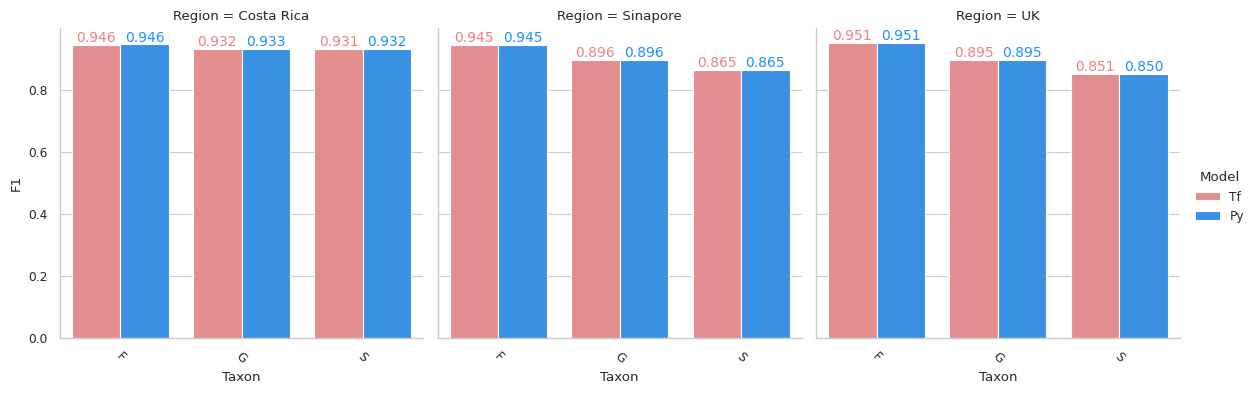

In [50]:
# Plot the results
sns.set_style('whitegrid')
sns.set_context('paper')

g = sns.catplot(x='Taxon', y='F1', hue='Model', col='Region', 
                data=df,
                kind='bar', height=4, aspect=1, palette=['lightcoral', 'dodgerblue'])

#add values to top of bars
for ax in g.axes.flat:
    for p in ax.patches:        
        # if the value is in -0.2, 0.8, or 1.8 then light coral else dodger blue
        if p.get_x()+ p.get_width()/2 in [-0.2, 0.8, 1.8]:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.3f' % p.get_height(), 
                    fontsize=10, color='lightcoral', ha='center', va='bottom')
        else:
            ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.3f' % p.get_height(), 
                    fontsize=10, color='dodgerblue', ha='center', va='bottom')
            
g.set_xticklabels(rotation=-45)

plt.savefig('./outputs/plots/f1_scores.png', dpi=300, bbox_inches='tight')


# Confusion Matrices

In [ ]:
# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.set_context('paper')

def create_cf(json_names, str_head='F'): 
    # create a confusion matrix for F_Truth and F_Tf_Prediction
    inp = str_head + '_Truth'
    inp2 = str_head + '_Tf_Prediction'
    confusion = pd.crosstab(conf[inp], conf[inp2], margins=True)
        
    # F=family, G=genus, S=species
    if str_head == 'F':
        names = json_names['family_list']
    elif str_head == 'G':
        names = json_names['genus_list']
    elif str_head == 'S':
        names = json_names['species_list']

    # convert the confusion index to the family names
    confusion.index = [names[x] for x in confusion.index[:-1]] + ['All']
    confusion.columns = [names[x] for x in confusion.columns[:-1]] + ['All']

    return(confusion)

def create_cf_matrix(confusion, spec='', save=False, spec2='', fs=(6.5, 8)):
    plt.figure(figsize=fs)

    gs = plt.GridSpec(2, 2, width_ratios=[1, 0.07], height_ratios=[0.07, 1], wspace=0.01, hspace=0.01)

    # Plot the heatmap with continuous values
    ax_heatmap = plt.subplot(gs[1, 0])
    ax_row_annotation = plt.subplot(gs[1, 1])
    ax_col_annotation = plt.subplot(gs[0, 0])

    conf2 = confusion.iloc[:-1, :-1]
    plt.title(spec + ' Confusion Matrix for ' + spec2 + 'Model')

    # plot the confusion matrix with annotation row for the 'All' column
    g = sns.heatmap(conf2, annot=True, cmap='Blues', cbar=False, ax=ax_heatmap, fmt='.0f', annot_kws={'size': 8})
    g.set_xlabel('Predicted')
    g.set_ylabel('Actual')
    g.set_xticklabels(g.get_xticklabels(), rotation=-45, ha='left')

    ra = sns.heatmap(pd.DataFrame({'feature2': confusion['All'][:-1]}), annot=True,fmt='.0f',
                cmap='Reds', annot_kws={'size': 8}, ax=ax_row_annotation, 
                cbar=False, xticklabels=False, yticklabels=False)
    ra.set_xlabel('Total', rotation=-45, ha='left')


    ca = sns.heatmap(pd.DataFrame({'feature1': confusion.loc['All',][:-1]}).transpose(), 
                cmap='Reds', annot_kws={'size': 8, 'rotation': 90}, 
                ax=ax_col_annotation, annot=True,fmt='.0f',
                cbar=False, xticklabels=False, yticklabels=False)
    ca.set_ylabel('Total')


    if save:
        plt.savefig('./outputs/plots/' + spec2 + '_confusion_' + spec + '.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [ ]:
# load in the confusion data
import pandas as pd

conf = pd.read_csv('./outputs/costarica_resnet_v2.0_confusion-data.csv')

# read in the family names from the json
with open("/bask/homes/f/fspo1218/amber/data/gbif_costarica/01_costarica_data_numeric_labels.json", 'r') as f:
    json_names = json.load(f)

In [ ]:
fam_cf = create_cf(json_names, str_head='F')
#create_cf_matrix(fam_cf, spec = "Family", spec2='Costa Rica', save=True)

gen_cf = create_cf(json_names, str_head='G')
# create_cf_matrix(gen_cf, spec = "Genus", spec2='Costa Rica', save=True)

spec_cf = create_cf(json_names, str_head='S')
# create_cf_matrix(spec_cf, spec = "Species", spec2='Costa Rica', save=True)


In [ ]:
conf = pd.read_csv('./outputs/uk_resnet_v2.0_confusion-data.csv')

# read in the family names from the json
with open("/bask/homes/f/fspo1218/amber/data/gbif_uk/01_uk_data_numeric_labels.json", 'r') as f:
    json_names = json.load(f)
    
fam_cf = create_cf(json_names, str_head='F')
create_cf_matrix(fam_cf, spec = "Family", spec2='UK', save=True, fs=(12, 12))

In [ ]:
conf = pd.read_csv('./outputs/singapore_resnet_v2.0_confusion-data.csv')

# read in the family names from the json
with open("/bask/homes/f/fspo1218/amber/data/gbif_singapore/01_singapore_data_numeric_labels.json", 'r') as f:
    json_names = json.load(f)
    
fam_cf = create_cf(json_names, str_head='F')
create_cf_matrix(fam_cf, spec = "Family", spec2='Singapore', save=True, fs=(12, 12))

# Taxon Accuracy

In [ ]:
cr_taxon.keys()



In [ ]:
# Plot the accuracy for each species as a line chart with the test points as a bar chart behind
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')
sns.set_context('paper')

# for each species get the accuracy and the number of test points
def taxon_acc_plot(taxon_json, model='TFLite', taxon='species', region='Costa Rica'):
    tax_accuracy = taxon_json[model][taxon]

    tax = []
    accuracy = []
    test_points = []
    for k, v in tax_accuracy.items():
        tax.append(k)
        accuracy.append(v[0])
        test_points.append(v[1])
        
    # create a df with the species, accuracy and test points
    df = pd.DataFrame({'Taxon': tax, 'Accuracy': accuracy, 'Test Points': test_points})
    #df['species_numeric'] = np.arange(len(df))
    
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 3))

    # Plot accuracy on the left y-axis (line chart)
    color = 'tab:red'
    ax1.set_xlabel(taxon.capitalize())
    ax1.set_ylabel('Test Points', color=color)
    ax1.bar(df['Taxon'], df['Test Points'], color=color, alpha=0.5)
    ax1.tick_params(axis='y', labelcolor=color)


    # rotate the x labels
    ax1.set_xticklabels(df['Taxon'].values, rotation=-45, ha='left')

    # Create a second y-axis for test points (bar chart)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(df['Taxon'].values, df['Accuracy'].values, color=color, marker='o')
    ax2.tick_params(axis='y', labelcolor=color)


    # Adjust layout
    plt.title('Accuracy by ' + taxon.capitalize() + ' for ' + region + ' Model')
    return fig, ax1, ax2       

In [ ]:
# for family, genus, species plot the accuracy and test points
fig, ax1, ax2 = taxon_acc_plot(uk_taxon, taxon='family', region='UK')
fig.savefig('./outputs/plots/taxon/uk_family_acc.png', dpi=300, bbox_inches='tight')
fig, ax1, ax2 = taxon_acc_plot(uk_taxon, taxon='genus', region='UK')
fig.savefig('./outputs/plots/taxon/uk_genus_acc.png', dpi=300, bbox_inches='tight')
fig, ax1, ax2 = taxon_acc_plot(uk_taxon, taxon='species', region='UK')
fig.savefig('./outputs/plots/taxon/uk_species_acc.png', dpi=300, bbox_inches='tight')

In [ ]:
# for family, genus, species plot the accuracy and test points
fig, ax1, ax2 = taxon_acc_plot(si_taxon, taxon='family', region='Singapore')
fig.savefig('./outputs/plots/taxon/si_family_acc.png', dpi=300, bbox_inches='tight')
fig, ax1, ax2 = taxon_acc_plot(si_taxon, taxon='genus', region='Singapore')
fig.savefig('./outputs/plots/taxon/si_genus_acc.png', dpi=300, bbox_inches='tight')
fig, ax1, ax2 = taxon_acc_plot(si_taxon, taxon='species', region='Singapore')
fig.savefig('./outputs/plots/taxon/si_species_acc.png', dpi=300, bbox_inches='tight')

In [ ]:
# for family, genus, species plot the accuracy and test points
fig, ax1, ax2 = taxon_acc_plot(cr_taxon, taxon='family')
fig.savefig('./outputs/plots/taxon/cr_family_acc.png', dpi=300, bbox_inches='tight')
fig, ax1, ax2 = taxon_acc_plot(cr_taxon, taxon='genus')
fig.savefig('./outputs/plots/taxon/cr_genus_acc.png', dpi=300, bbox_inches='tight')
fig, ax1, ax2 = taxon_acc_plot(cr_taxon, taxon='species')
fig.savefig('./outputs/plots/taxon/cr_species_acc.png', dpi=300, bbox_inches='tight')